In [1]:
import pandas as pd

checkins = pd.read_csv('comboframe.csv', usecols=['beer_id', 'rating_user',
                                                  'rating_global', 'user_id',
                                                  'abv', 'brewery_name',
                                                  'beer_style', 'beer_name',
                                                  'checkin_id'])
# only allow each user one rating for each beer
checkins.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)
print(checkins.shape)
descrips = pd.read_csv('descriptions.csv')
print(descrips.shape)

(1894852, 9)
(114347, 2)


In [2]:
# merge in the descriptions and see how many checkins remain
checkins = checkins.merge(descrips, how='inner')
checkins.shape

(1394388, 10)

Use only checkins from users with over 25 checkins

In [3]:
checkins = checkins[checkins.user_id.map(checkins.groupby('user_id').size() > 24)]
checkins.shape

(982165, 10)

Use only checkins for beers that have over 5 checkins

In [4]:
checkins = checkins[checkins.beer_id.map(checkins.groupby('beer_id').size() > 4)]
checkins.shape

(836668, 10)

In [5]:
# remove the ones with no global ratings
checkins.dropna(subset=['rating_global'], axis=0, inplace=True)
# and the zeros
checkins = checkins[checkins.rating_global > 0]
checkins.shape

(824212, 10)

In [6]:
# get rid of non-beers
# Those will mess up the predictions, since abv is a strong correlator with ratings.
checkins = checkins[(checkins.abv > 0) & (checkins.abv < 30)]
checkins[['abv']].describe()

,abv
count,823020.000000
mean,6.957658
std,2.009194
min,0.300000
25%,5.600000
50%,6.700000
75%,8.000000
max,28.000000


In [26]:
# now that some beers were cut out, some users went to fewer than 25 checkins
checkins = checkins[checkins.user_id.map(checkins.groupby('user_id').size() > 24)]
checkins.shape

(821799, 10)

In [27]:
# a mapping from user to number of ratings can be helpful in many situations
usercounts = checkins.groupby('user_id').size()

In [8]:
import numpy as np

In [9]:
# make a func to deal with ties in rankings
def untied_rank(arr, vals):
    '''
    Measure how well the input vals (list or np.array) has chosen
    the top values of input arr (np.array). 
    vals must be subset of arr.
    1.0 is perfect, 0.0 is worst.
    '''
    fails = 0
    poss_fails = 0
    ordered = np.sort(arr)
    if max(ordered) == min(ordered): return 0.5  # like guessing, if all equal
    for i in range(len(vals)):
        fails += sum(arr > vals[i])
        arr = np.delete(arr, np.where(arr == vals[i])[0][0])
        poss_fails += sum(ordered > ordered[i])
    
    return 1 - fails / poss_fails

In [28]:
checkins.head(1)

,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description
0,821797539,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,Stone Brewing Stone Scorpion Bowl IPA To creat...


Get the beer name and brewer name in the description bag of words

In [12]:
# Add the beer and brewery names to the description
checkins['beer_description'] = checkins.brewery_name + ' ' + checkins.beer_name + ' ' + checkins.beer_description

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor

### Build a bag of words model for each user, but make vectors based on each user too, unlike other notebooks

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from scipy.sparse import csr_matrix, hstack
from tqdm import tqdm

#### What to target during training? You'd think the user rating, but that forces the model to learn the global mean of the beer.  Should be more accurate to target the user deviation from the expected sum of global mean plus user generosity.

Need to split train-test groups now to calculate what's being targeted but only on the training portion.

In [55]:
def split_last_X(frame, countDict, X):
    '''
    Split the input frame into training and testing,
    using the last X for each user as testers.
    CountDict input has the rows per user,
    and the frame is indexed by user.
    Returns the train split and test split
    '''
    boollist = [[True] * (countDict[u] - X) + [False] * X for u in frame.index.unique()]
    boollist = np.array([boo for lis in boollist for boo in lis])  # numpy to help with the logic
    
    return frame[boollist], frame[~boollist]

In [29]:
traindf, testdf = split_last_X(checkins.set_index('user_id'), usercounts, X=10)

In [31]:
print(traindf.index.nunique())
print(len(testdf))

7410
74100


In [ ]:
gbr = GradientBoostingRegressor()
resultdict2 = dict()
cv = CountVectorizer(stop_words='english', binary=True, min_df=2, max_df=0.6)

for u in tqdm(traindf.index.unique()):
    udf = checkins.set_index('user_id').loc[u]
    udf['udiffs'] = udf.rating_user.values - udf.rating_global.values
    # calculate the mean udiff just on the non-testers
    known_bias = np.mean(udf.udiffs.values[:-10])
    # subtract that mean from the diffs to get the known devs
    udf['udevs'] = udf.udiffs.values - known_bias
    # fit the countvec on all rows
    uvecs = cv.fit_transform(udf.beer_description)
    uvecs = hstack([uvecs, udf.abv.values[:, np.newaxis] / 5.0])  # need the new axis for hstack
    uvecs = csr_matrix(uvecs)  # it mutated to coo from csr somewhere in there
    # fit the model on all but last ten checkins
    gbr.fit(uvecs[:-10, :], udf.udevs.values[:-10])
    # predict the last ten for each user, adding the predicted deviation to the userbias and glob_mean
    preds = gbr.predict(uvecs[-10:, :]) + udf.rating_global.values[-10:] + known_bias
    preds = np.clip(preds, 0.25, 5.0)
    targets = udf.rating_user.values[-10:]
    diffs = preds - targets
    sumsq = np.dot(diffs, diffs)
    rmse = np.sqrt(sumsq / len(diffs))
    
    resultdict2[u] = (len(udf)-10, rmse, preds)                     


 73%|███████▎  | 5442/7410 [2:00:58<851:17:05, 1557.23s/it]

In [193]:
print(f'mean RMSE using min_df=2 and max_df=0.6 is {np.mean([v[1] for v in resultdict2.values()])}')

mean RMSE using min_df=2 and max_df=0.6 is 0.4378824460981507


(resultdict2, above, uses min_df=0.6, and resultdict, below, uses min_df=0.25

In [120]:
print(f'mean RMSE using min_df=2 and max_df=0.25 is {np.mean([v[1] for v in resultdict.values()])}')

mean RMSE using min_df=2 and max_df=0.25 is 0.4389212087943475


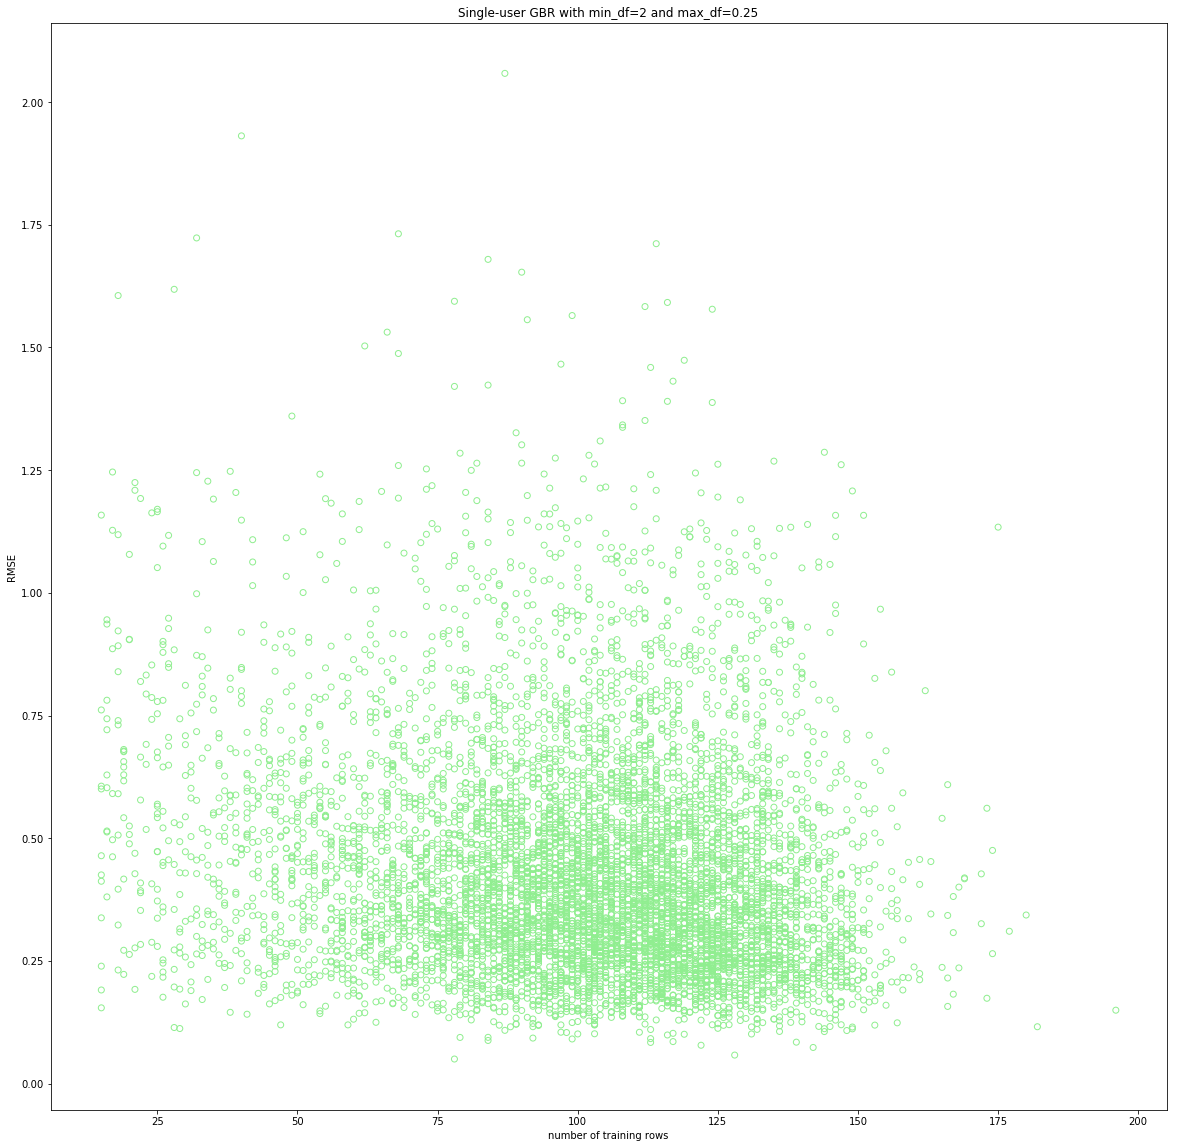

In [122]:
plt.figure(figsize=(20,20))
plt.scatter([v[0] for v in resultdict.values()], [v[1] for v in resultdict.values()],
           edgecolor='lightgreen', facecolor='none')
plt.xlabel('number of training rows')
plt.ylabel('RMSE')
plt.title('Single-user GBR with min_df=2 and max_df=0.25');

In [132]:
# bin the rmses by training size to plot line
results_by_size = [(v[0],v[1]) for v in resultdict.values()]
result_df = pd.DataFrame(results_by_size, columns=['checkins', 'rmse'])
result_df.head()

,checkins,rmse
0,104,0.701169
1,101,0.663305
2,91,0.793637
3,108,0.522110
4,117,0.220361


In [ ]:
# resultdict and result_df have (size, GBR RMSE, GBR preds)

In [140]:
result_df['bin'] = pd.cut(result_df.checkins, bins=range(15,200,30))

In [141]:
groups = result_df.groupby('bin')['rmse'].mean()
groups

bin
(15, 45]      0.564875
(45, 75]      0.472553
(75, 105]     0.442744
(105, 135]    0.422253
(135, 165]    0.381920
(165, 195]    0.371298
Name: rmse, dtype: float64

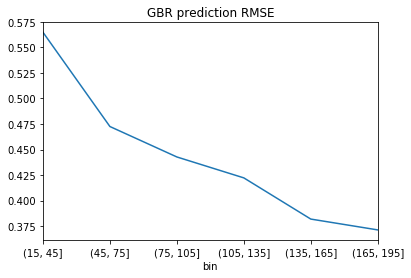

In [175]:
groups.plot(title='GBR prediction RMSE')

and the ranking accuracy for those same predictions:

In [165]:
# make sure the results are for the same users and checkins

results_with_accuracy = dict()

for u in tqdm(resultdict.keys()):
    udf = checkins.set_index('user_id').loc[u]
    targets = udf.rating_user.values[-10:]
    rank_acc = untied_rank(targets, targets[np.argsort(resultdict[u][2])[:-4:-1]])
    results_with_accuracy[u] = (resultdict[u][0], rank_acc, resultdict[u][1])


100%|██████████| 7410/7410 [25:33<00:00,  4.94it/s]


In [166]:
plot_df = pd.DataFrame(results_with_accuracy.values(),
                      columns=['size', 'rank_acc', 'rmse'])

In [ ]:
plot_df['bin'] = pd.cut(plot_df["size"], bins=range(15,200,30))

In [174]:
plot_df.groupby('bin').mean()

,size,rank_acc,rmse
bin,,,
"(15, 45]",32.366667,0.673977,0.564875
"(45, 75]",62.792111,0.717958,0.472553
"(75, 105]",92.417656,0.735634,0.442744
"(105, 135]",119.406540,0.759487,0.422253
"(135, 165]",143.322531,0.786572,0.381920
"(165, 195]",171.000000,0.818459,0.371298


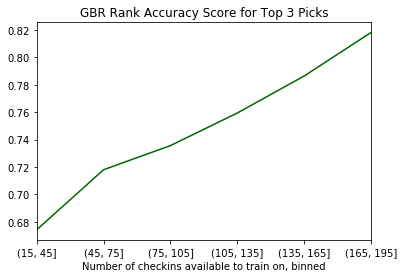

In [183]:
plot_df.groupby('bin').rank_acc.mean().plot(title='GBR Rank Accuracy Score for Top 3 Picks', color='darkgreen')
plt.xlabel('Number of checkins available to train on, binned');

In [164]:
np.mean([v[1] for v in results_with_accuracy.values()])

0.71197809656522604

In [152]:
plot_df.c1.values == plot_df.c2.values

array([ True], dtype=bool)

In [153]:
plot_df.head()

,c1,rmse,rank_acc,c2
0,22,0.352784,0.705882,22


Compare to global mean predictions for same test group

In [143]:
useresults = dict()
for u in tqdm(traindf.index.unique()):
    udf = checkins.set_index('user_id').loc[u]  # fyi these aren't chronologically ordered
    udf['udiffs'] = udf.rating_user.values - udf.rating_global.values
    # calculate user bias on all but last ten rows, then add that to global mean to get preds
    ubias = np.mean(udf.udiffs.values[:-10])
    preds = udf.rating_global.values[-10:] + ubias
    last_ten = udf.rating_user.values[-10:]
    diffs = preds - last_ten
    rmse = np.sqrt(np.dot(diffs, diffs) / 10)
    rank_acc = untied_rank(last_ten, last_ten[np.argsort(preds)[:-4:-1]])
    
    useresults[u] = (len(udf) - 10, rmse, rank_acc)


100%|██████████| 7410/7410 [29:27<00:00,  4.18it/s]


In [145]:
urdf = pd.DataFrame(useresults.values(), columns=['checkins','rmse','rank_acc'])
urdf['bins'] = pd.cut(urdf.checkins, bins=range(15,200,30))
rmse_bins = urdf.groupby('bins')['rmse'].mean()
rank_bins = urdf.groupby('bins')['rank_acc'].mean()

In [146]:
rmse_bins

bins
(15, 45]      0.497025
(45, 75]      0.419695
(75, 105]     0.394745
(105, 135]    0.377636
(135, 165]    0.348202
(165, 195]    0.313550
Name: rmse, dtype: float64

In [147]:
rank_bins

bins
(15, 45]      0.733622
(45, 75]      0.744358
(75, 105]     0.754062
(105, 135]    0.781862
(135, 165]    0.797366
(165, 195]    0.806502
Name: rank_acc, dtype: float64

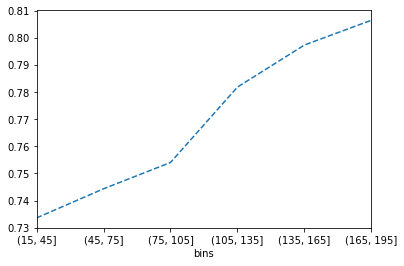

In [188]:
rank_bins.plot(style='--')

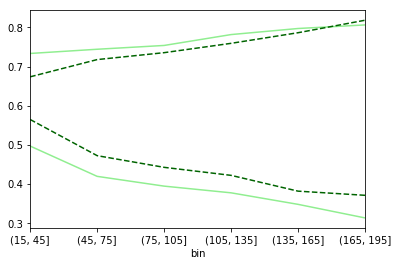

In [190]:
rmse_bins.plot(color='lightgreen')
rank_bins.plot(color='lightgreen')
plot_df.groupby('bin').rank_acc.mean().plot(style='--', color='darkgreen')
groups.plot(style='--', color='darkgreen');

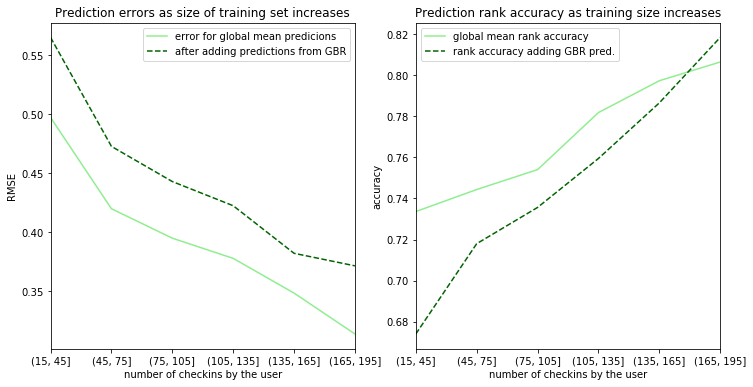

In [197]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
rmse_bins.plot(color='lightgreen', label='error for global mean predicions')
groups.plot(style='--', color='darkgreen', label='after adding predictions from GBR')
plt.title('Prediction errors as size of training set increases')
plt.ylabel('RMSE')
plt.xlabel('number of checkins by the user')
plt.legend()

plt.subplot(122)
rank_bins.plot(color='lightgreen', label='global mean rank accuracy')
plot_df.groupby('bin').rank_acc.mean().plot(style='--', color='darkgreen', label='rank accuracy adding GBR pred.')
plt.ylabel('accuracy')
plt.xlabel('number of checkins by the user')
plt.title('Prediction rank accuracy as training size increases')
plt.legend()

plt.show()

In [94]:
gbr = GradientBoostingRegressor()
# loop over all users
resultdict = dict()
for u in tqdm(traindf.index.unique()):
    # initialize the bests
    best_score = 5
    best_params = None
     
    # manual gridsearch
    for mindf in [2,4,6]:  # was gonna include mindf=1 but then a word would be in the train set but not test
        for maxdf in [.2, .4, .6, .8]:
            # a WHOLE NEW cv for all 12 param combos for all 7410 users!  training 84K models
            cv = CountVectorizer(stop_words='english', binary=True, min_df=mindf, max_df=maxdf)
            udf = checkins.set_index('user_id').loc[u]
            udf['udiffs'] = udf.rating_user.values - udf.rating_global.values
            # calculate the mean udiff just on the non-testers
            known_bias = np.mean(udf.udiffs.values[:-10])
            # subtract that mean from the diffs to get the known devs
            udf['udevs'] = udf.udiffs.values - known_bias
            # fit the countvec on all rows
            uvecs = cv.fit_transform(udf.beer_description)
            uvecs = hstack([uvecs, udf.abv.values[:, np.newaxis] / 5.0])  # need the new axis for hstack
            uvecs = csr_matrix(uvecs)  # it mutated to coo from csr somewhere in there
            gbr.fit(uvecs[:-10, :], udf.udevs.values[:-10])

            preds = gbr.predict(uvecs[-10:, :]) + udf.rating_global.values[-10:] + known_bias
            pred = np.clip(preds, 0.25, 5.0)
            targets = udf.rating_user.values[-10:]
            diffs = preds - targets
            sumsq = np.dot(diffs, diffs)
            rmse = np.sqrt(sumsq / len(diffs))
            #updates
            if rmse < best_score:
                best_score = rmse
                best_params = (mindf, maxdf)
    resultdict[u] = (best_score, best_params)                     
                          


  9%|▉         | 686/7410 [42:18<6:51:58,  3.68s/it] 

ValueError: max_df corresponds to < documents than min_df

In [95]:
np.mean([v[0] for v in resultdict.values()])

0.38812398615744281

In [96]:
max([v[0] for v in resultdict.values()])

1.8502418160992549

In [103]:
from collections import Counter
tups = Counter([v[1] for v in resultdict.values()])

In [104]:
tups.most_common()

[((6, 0.2), 82),
 ((2, 0.2), 76),
 ((4, 0.2), 62),
 ((6, 0.4), 61),
 ((2, 0.8), 60),
 ((6, 0.8), 57),
 ((4, 0.4), 54),
 ((6, 0.6), 50),
 ((2, 0.4), 49),
 ((4, 0.8), 47),
 ((4, 0.6), 45),
 ((2, 0.6), 43)]

In [108]:
sizes = checkins.groupby('user_id').size()
ucounts = {u: sizes[u] for u in resultdict}

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

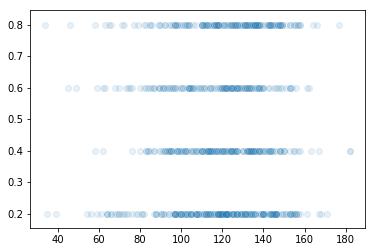

In [117]:
plt.scatter([ucounts[u] for u in resultdict], [resultdict[u][1][1] for u in resultdict], alpha = 0.1)